In [97]:
from final_utils import make_savedir, train_and_test, load_from_savedir, load_nips_data

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from observations import nips
import os
%matplotlib inline

# Introduction

In this notebook, we'll go through various steps of Box's Loop for Deep Exponential Familes (DEFs) (Ranganath et al., 2015), applied to abstracts from the machine learning conference NIPS. We'll extend the model to include residual and skip connections between layers, which are inspired by the success of deep residual networks in deep learning (He et al., 2016).

## Data

We begin by loading the dataset: abstracts from the machine learning conference NIPS. We only include words that are in at least two documents and have appeared in at least ten different abstracts. The final corpus has 11,463 documents and 11,431 word tokens.

In [99]:
x_full, words = load_nips_data()

# Introducing Deep Exponential Families

In this notebook, we'll focus on Deep Exponential Families, and in particular, the sparse gamma DEF. We focus on this DEF for one key reason: the latent variables are continuous, so it's possible to analyze in a probabilistic programming approach. 


The model is as follows. For each data point $x_n$ (which is itself a vector designating the word count of each document), we have $L$ layers of hidden variables, $\{\boldsymbol z_{n,1}, \dots, \boldsymbol z_{n,L}\}$ (each of these is a vector). We also have $L - 1$ layers of weights $\{\boldsymbol W_1, \dots, \boldsymbol W_{L-1}\}$, each of which is a matrix of independent variables with sparse gamma priors, meaning each element $w \sim \text{Gamma}(\alpha, \beta)$ with $\alpha < 1$. The top most layer of latent variables $L$ is a vector where each element has a prior $z_{L,k} \sim \text{Gamma}(\alpha_L, \beta_L)$.

Each set of layers and weights are connected via 

$$p(z_{n, l,k} | \boldsymbol z_{n, l+1}, \boldsymbol w_{l,k}) = \text{Gamma}\left(\alpha_l, \frac{\alpha_l}{\boldsymbol z_{n, l+1}^T \boldsymbol w_{l,k}}\right).$$

where $\alpha_l$ is a shape constant for layer l. Finally, the count of term $i$ in document $n$ (the data layer) is given by 

$$p(x_{n,i} | \boldsymbol z_{n, 1}, \boldsymbol W_0) = \text{Pois}(\boldsymbol z_{n,1}^T \boldsymbol w_{0, i}).$$

This statistical model is used because the deep nature of the model allows practioners to uncover topics and "super-topics," which find structure between the latent topics. Additionally, inference is straightforward with Blackbox Variational Inference (BBVI) (Ranganath et al., 2014). Unlike other common deep models used for text, the probabilistic nature of DEFs allow for interpretive inferences.

## Model

For all our experiments, we use $\alpha = 0.1, \beta = 0.3,$ and $\alpha_l = 0.1$ for all $l$, follwing Ranganath et al., 2014. We begin with a three-layer model, where $\boldsymbol z_{n, 1}$ is 100-dimensional, $\boldsymbol z_{n, 2}$ is 50-dimensoinal, and $\boldsymbol z_{n, 3}$ is 10-dimensional. 

In [100]:
K = [100, 50, 10]

## Inference

We perform inference with variational inference, for now using a lognormal variational approximation (for a discussion of lognormal vs gamma approximations, see the next section). Even within variational inference, two approaches are possible: using MAP-estimation to estimate the shared weights and a variational approach for the document parameters (Variational EM), or using a variational approach for both sets of parameters. One advantage of learning the weights with MAP estimation is that training may scale better since we're learning less parameters, while an advantage of the variational approach is that it more fully takes into account uncertainty and thus benefits from the usual advantages of Bayesian inference.

We start with the map estimation approach (ignore the skip variable for now).

In [101]:
skip = False
q = 'lognormal'
map_estimate = True
lr = 0.01

Each model takes a couple of hours to train, even on GPU, so we're pre-loading data. If you want to retrain, set the "rerun" parameter equal to True.

In [102]:
rerun = False

In [103]:
if rerun:
    ln_map_100_50_10 = make_savedir(K, skip=skip, q=q, map_estimate=map_estimate, lr=lr)
    perps_map, losses_map, zs_map, ws_map = train_and_test(K, ln_map_100_50_10, skip, q=q, lr=lr, 
                                       n_iter_per_epoch=25000, map_estimate=map_estimate, 
                                       n_test_epoch=50)
else:
    ln_map_100_50_10 = 'info/20171128_230116_nips_100_50_10_lognormal_lr_0.01_map'
    perps_map, losses_map, zs_map, ws_map = load_from_savedir(ln_map_100_50_10, K)

Now try being fully Bayesian.

In [104]:
map_estimate = False

In [105]:
if rerun:
    ln_rand_100_50_10 = make_savedir(K, skip=skip, q=q, map_estimate=map_estimate, lr=lr)
    perps_rand, losses_rand, zs_rand, ws_rand = train_and_test(K, ln_rand_100_50_10, skip, q=q, lr=lr, 
                                       n_iter_per_epoch=25000, map_estimate=map_estimate, 
                                       n_test_epoch=50)
else:
    ln_rand_100_50_10 = 'info/20171129_031053_nips_100_50_10_lognormal_lr_0.01'
    perps_rand, losses_rand, zs_rand, ws_rand = load_from_savedir(ln_rand_100_50_10, K)

## Criticism

To evaluate the model, we use text perplexity, a common way to evaluate topic models (Wallach et al., 2009). More specifically, we first set aside 1,000 documents and train on the remaining 10,463 documents. Within the 1,000 test documents, we keep 20% of each document and use the remaining 80% for testing. We fix the variational means of the shared weight parameters, and learn the per-document parameters on the 20% that we have of each held-out document. As we learn the per-document $\boldsymbol z$'s, we evaluate perplexity on the remaining 80% of each held-out document, given by

$$ \exp\left(-\frac{\sum_{d \in \text{docs}}\sum_{w \in d} \log p(w | \text{number of held out terms in } d)}{N_{\text{held out words}}}\right).$$

Below, after training on the training set for 25,000 iterations, we evaluate the held-out perplexity at every epoch. 

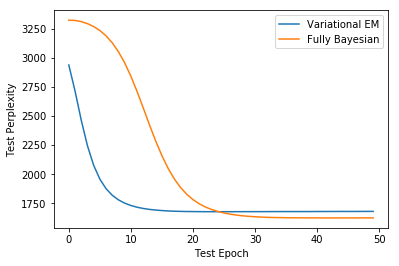

In [106]:
plt.plot(range(len(perps_map)), perps_map, label="Variational EM")
plt.plot(range(len(perps_rand)), perps_rand, label="Fully Bayesian")
plt.xlabel("Test Epoch")
plt.ylabel("Test Perplexity")
plt.legend()

As one may expect, our perplexities are initially better when the $\boldsymbol W$'s are point estimates, but eventually the fully Bayesian approach is advantageous. That is, even though the Bayesian approach involves more computation, it produces better results since it's better able to take advantage of uncertainty.

Below, we analyze some of the learned topics.

In [107]:
word_groups = {}
for k in range(100):
    top_words_idx = ws_rand[0][k, :].argsort()[-7:][::-1]
    top_words = " ".join([words[i] for i in top_words_idx])
    if k % 30 == 0:
        print("Topic {}: {}".format(k, top_words))
    word_groups[k] = top_words

Topic 0: graph graphs edge edges nodes random vertices
Topic 30: level hierarchical hierarchy levels resolution high scale
Topic 60: test risk tests statistic confidence bootstrap testing
Topic 90: query ranking queries search rank retrieval hashing


Recall, an advantage of DEFs is the recovery of super-topics. Below, we look at some handpicked super-topics that correspond to variational inference, reinforcement learning, and Bayesian topic models, respectively.

In [108]:
good_super_topics = [10, 21, 46]
for i in good_super_topics:
    top_groups_idx = ws_rand[1][i, :].argsort()[-3:][::-1]
    top_groups = 'Super Topic '+ str(i) + ': ' + '\n' + '\n'.join([word_groups[i] for i in top_groups_idx])
    print(top_groups + '\n')

Super Topic 10: 
network networks training units neural hidden weights
bayesian posterior prior gaussian inference variational distribution
energy field mean free temperature theory equations

Super Topic 21: 
policy state value function reinforcement optimal action
theorem bound let bounds probability proof lemma
regret game algorithm strategy games player bandit

Super Topic 46: 
topic topics document lda dirichlet documents latent
bayesian posterior prior gaussian inference variational distribution
model models parameters data likelihood latent log



# Lognormal or Gamma?

That model worked well, but why did we decide on a lognormal variational approximation? Below we explore another possibility.

## Model

For sake of efficiency, we use a smaller model for this comparison: 2 layers with 50 dimensions and 25 dimensions.

In [109]:
K = [50, 25]

## Inference

We begin with a Gamma variational approximation. The Gamma approximation has the advantage that it matches the data distribution, so it should be able to pick up the desired spike-and-slab shape in the posterior distribution. However, we do inference with Blackbox Variational Inference (BBVI) (Ranganath et al., 2014) , which can have very high variance for the gradients, especially since Edward doesn't implement control variates.

In [110]:
skip = False
map_estimate = False
q = 'gamma'
lr = 0.1

In [111]:
if rerun:
    gamma_50_25 = make_savedir(K, skip=skip, q=q, map_estimate=map_estimate, lr=lr)
    perps_gamma, losses_gamma, zs_gamma, ws_gamma = train_and_test(K, gamma_50_25, skip, 
                                       q=q, lr=lr, n_iter_per_epoch=4000, 
                                       map_estimate=map_estimate, n_test_epoch=10)
else:
    gamma_50_25 = 'info/20171129_002902_nips_50_25_gamma_lr_0.1'
    perps_gamma, losses_gamma, zs_gamma, ws_gamma = load_from_savedir(gamma_50_25, K)

Meanwhile, a Lognormal approximation does not have the spike-and-slab shape desired in topic models, but the gradients are reparameterizable. That is, since a sample from the variational distribution can be reparameterized as a function from a standard normal distribution appropriately exponentiated, scaled, and shifted by the variational parameters, we can take stochastic gradients with respect to these parameters using the parameterization trick (Kingma and Welling, 2014). This is a lower-variance estimation strategy.

In [80]:
q = 'lognormal'

In [81]:
if rerun:
    ln_50_25 = make_savedir(K, skip=skip, q=q, map_estimate=map_estimate, lr=lr)
    perps_ln, losses_ln, zs_ln, ws_ln = train_and_test(K, ln_50_25, skip, 
                                       q=q, lr=lr, n_iter_per_epoch=4000, 
                                       map_estimate=map_estimate, n_test_epoch=10)
else:
    ln_50_25 = 'info/20171129_004346_nips_50_25_lognormal_lr_0.1'
    perps_ln, losses_ln, zs_ln, ws_ln = load_from_savedir(ln_50_25, K)

## Criticism

We first observe the training log-likelihood.

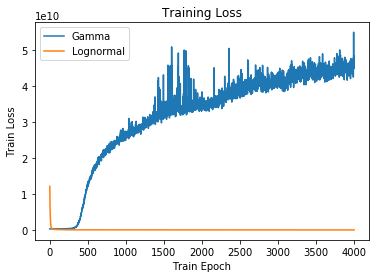

In [112]:
plt.plot(range(len(losses_gamma)), losses_gamma, label="Gamma")
plt.plot(range(len(losses_ln)), losses_ln, label="Lognormal")
plt.legend()
plt.ylabel("Train Loss")
plt.xlabel("Train Epoch")
plt.title("Training Loss")

Indeed, the Gamma approximation isn't even able to train to the data. This is likely due to high variance in the gradient estimates since Edward doesn't implement control variates. I tried adding control variates to Edward, but due to the way TensorFlow aggregates gradients across samples, my implementation added a lot of extra training time. To use control variates, one can set the cv=True flag in the train_and_test function. 

As expected, the test perplexity is also far worse.

In [113]:
print("Gamma Test Perplexity: ", round(perps_gamma[-1], 1))
print("Lognormal Test Perplexity: ", round(perps_ln[-1], 1))

Gamma Test Perplexity:  237348.7
Lognormal Test Perplexity:  1870.3


Thus, we stick to lognormal approximations. 

# Introducing skip and residual connections

## Model

Most of the literature on DEFs looks at shallow models, since it becomes much more difficult to train on deeper models. One intuitive reason is vanishing gradients; specifically, imagine that the gradient for a layer vanishes and all the weight parameters are set to be very small; then

$$E(z_{n, l,k} | \boldsymbol z_{n, l+1}, \boldsymbol w_{l, k}) = \boldsymbol z_{n, l+1}^T \boldsymbol w_{l, k} \to 0.$$

Thus, all future layers and the output would become zero due to one set of weights going to zero, limiting the depth of practical models. 

Rather than adjusting the inference scheme, we adjust the model to account for this. In deep learning, deep residual networks (He et al., 2016) prevent the vanishing gradient problem by adding identity connections between layers in addition to the matrix product with nonlinearity, so that when the weights are 0, the layer can still learn the identity function. In particular, they use skip connections so that if the other input to the further layer vanishes, the model will still automatically pick up the identity. In this way, early layers in the network are still crucial for deeper layers, so that in the worst case scenario, the model could still output the shallow network.

The analogous model for sparse-gamma DEFs is as follows. If we model 

$$z_{n, l, k} | \boldsymbol z_{n, l+1}, \boldsymbol w_{l,k} \sim \text{Gamma}\left(\alpha_l, \frac{\alpha_l}{\boldsymbol z_{n, l+1}^T\boldsymbol w_{l,k} + \boldsymbol z_{n, l+1}^T}\right),$$

if the weights go to zero, we have the nice property that $E(z_{n, l,k}|\boldsymbol z_{n, l+1}, \boldsymbol w_{l,k}) = \boldsymbol z_{n, l+1}$. We'll refer to this as a **residual connection**.

A similar idea is the **skip connection**: here, we add the output of two previous layers as opposed to the most recent one, adding another source of stability:
$$z_{n, l, k} | \boldsymbol z_{n, l+1}, \boldsymbol z_{n, l+2}, \boldsymbol w_{l,k} \sim \text{Gamma}\left(\alpha_l, \frac{\alpha_l}{\boldsymbol z_{n,l+1}^T\boldsymbol w_{l,k} + \boldsymbol z_{n,l+2}^T}\right).$$

These connections are only defined for consecutive layers that have the same latent dimension. Thus, we begin with a deep model with 3 100-dimensional layers connected to 3 50-dimensional layers connected to 3 10-dimensional layers.   

We begin with the same model as above, with no skips or connections. 

In [22]:
K = [100, 100, 100, 50, 50, 50, 10, 10, 10]
skip = False
map_estimate = False
q = 'lognormal'
lr = 0.1

In [23]:
if rerun:
    deepest_noskip = make_savedir(K, skip=skip, q=q, map_estimate=map_estimate, lr=lr)
    perps_noskip, losses_noskip, zs_noskip, ws_noskip = train_and_test(K, deepest_noskip, 
                                        skip, q=q, lr=lr, n_iter_per_epoch=500, 
                                        map_estimate=map_estimate, n_test_epoch=3)
else:
    deepest_noskip = 'info/20171129_021335_nips_100_100_100_50_50_50_10_10_10_lognormal_lr_0.1'
    perps_noskip, losses_noskip, zs_noskip, ws_noskip = load_from_savedir(deepest_noskip, K)

We now add skip connections to every third layer. Specifically, for layer $l$, if $l$ mod $3$ is equal to 1, we sample

$$z_{n, l,k} \sim \text{Gamma}\left(\alpha_l, \frac{\alpha_l}{\boldsymbol z_{n, l+1}^T \boldsymbol w_{l,k} + \boldsymbol z_{n, l+2}^T}\right).$$

In [85]:
skip = True

In [25]:
if rerun:
    deepest_skip = make_savedir(K, skip=skip, q=q, map_estimate=map_estimate, lr=lr)
    perps_skip, losses_skip, zs_skip, ws_skip = train_and_test(K, deepest_skip, 
                                        skip, q=q, lr=lr, n_iter_per_epoch=500, 
                                        map_estimate=map_estimate, n_test_epoch=3)
else:
    deepest_skip = 'info/20171129_021024_nips_100_100_100_50_50_50_10_10_10_lognormal_lr_0.1_skip'
    perps_skip, losses_skip, zs_skip, ws_skip = load_from_savedir(deepest_skip, K)

## Inference

The inference model for both models is the same as above: fully Bayesian estimation with a lognormal variational approximation and reparameterization gradients.

## Criticism

The model without skip conncetions is unstable:

In [86]:
print("Last test perplexity without skips: ", round(perps_noskip[-1], 2))
print("Last test perplexity with skips: ", round(perps_skip[-1], 2))

Last test perplexity without skips:  2664.59
Last test perplexity with skips:  1616.97


We theorize this is due to the learning rate being set to $0.1$. Note that the model with skip connections did not suffer from this instability. Thus, we'll try again with a lower learning rate.

# Adjusting learning rate, adding residuals

## Model

We use the same models as above, with a lower learning rate. We also add a residual + skip model, which includes skip connections and residual connections whenever possible.

In [87]:
K = [100, 100, 100, 50, 50, 50, 10, 10, 10]
skip = False
map_estimate = False
q = 'lognormal'
lr = 0.01

In [88]:
if rerun:
    deepest_noskip = make_savedir(K, skip=skip, q=q, map_estimate=map_estimate, lr=lr)
    perps_noskip, losses_noskip, zs_noskip, ws_noskip = train_and_test(K, deepest_noskip, 
                                        skip, q=q, lr=lr, n_iter_per_epoch=40000, 
                                        map_estimate=map_estimate, n_test_epoch=50)
else:
    deepest_noskip = 'info/20171129_053526_nips_100_100_100_50_50_50_10_10_10_lognormal_lr_0.01'
    perps_noskip, losses_noskip, zs_noskip, ws_noskip = load_from_savedir(deepest_noskip, K)

In [89]:
skip = True

In [90]:
if rerun:
    deepest_skip = make_savedir(K, skip=skip, q=q, map_estimate=map_estimate, lr=lr)
    perps_skip, losses_skip, zs_skip, ws_skip = train_and_test(K, deepest_skip, 
                                        skip, q=q, lr=lr, n_iter_per_epoch=40000, 
                                        map_estimate=map_estimate, n_test_epoch=50)
else:
    deepest_skip = 'info/20171129_070703_nips_100_100_100_50_50_50_10_10_10_lognormal_lr_0.01_skip'
    perps_skip, losses_skip, zs_skip, ws_skip = load_from_savedir(deepest_skip, K)

In [31]:
residual = True

In [32]:
if rerun:
    deepest_res = make_savedir(K, skip=skip, q=q, map_estimate=map_estimate, lr=lr)
    perps_res, losses_res, zs_res, ws_res = train_and_test(K, deepest_res, 
                                        skip, q=q, lr=lr, n_iter_per_epoch=40000, 
                                        map_estimate=map_estimate, n_test_epoch=50,
                                        most_skip=residual)
else:
    deepest_res = 'info/20171129_083749_nips_100_100_100_50_50_50_10_10_10_lognormal_lr_0.01_most_skip'
    perps_res, losses_res, zs_res, ws_res = load_from_savedir(deepest_res, K)

## Inference

We use the same inference as above, except with a learning rate set to $0.01$. 

## Criticism

We begin evaluating by observing held out perplexity:

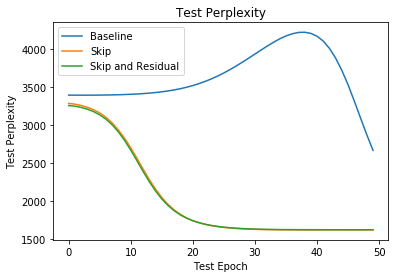

In [33]:
plt.plot(range(len(perps_noskip)), perps_noskip, label="Baseline")
plt.plot(range(len(perps_skip)), perps_skip, label="Skip")
plt.plot(range(len(perps_res)), perps_res, label="Skip and Residual")
plt.xlabel("Test Epoch")
plt.ylabel("Test Perplexity")
plt.title("Test Perplexity")
plt.legend()

This is an interesting result: although all models will eventually converge to the same test perplexity, it takes the baseline model much longer. Note that each model is estimating the same parameters; the only difference is in the skip and residual connections. It's also worth noting that the skip and full model (skip and residual) are nearly identical.

What's going on? This trend can partially be explained by looking at the distribution of $\boldsymbol W_{1}$. 

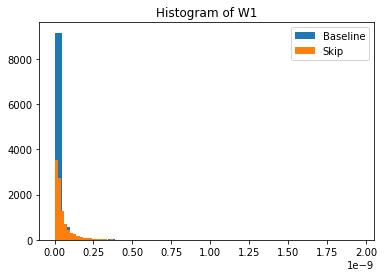

In [93]:
plt.hist(ws_noskip[1].flatten(), bins=40, label="Baseline")
plt.hist(ws_skip[1].flatten(), bins=40, label="Skip")
plt.title("Histogram of W1")
plt.legend()

Both models learn very low weight values for $\boldsymbol W_1$, on the scale of $10^{-9}$. The baseline model has

$$p(z_{n, 1 ,k} | \boldsymbol z_{n,2}, \boldsymbol w_{1,k}) = \text{Gamma}\left(\alpha_1, \frac{\alpha_1}{\boldsymbol z_{n, 2}^T \boldsymbol w_{1,k}}\right),$$

so low values of $\boldsymbol w_{1, k}$ naturally provide less information and take longer to train. Meanwhile, skip connections enjoy the property that

$$p(z_{n, 1 ,k} | \boldsymbol z_{n,2}, \boldsymbol w_{1,k}) = \text{Gamma}\left(\alpha_1, \frac{\alpha_1}{\boldsymbol z_{n, 2}^T \boldsymbol w_{1,k} + \boldsymbol z_{n, 3}}\right),$$
so that even if $\boldsymbol w_{1, k}$ goes down to 0, the network will still recover a previous layer. 

# Conclusion

Overall, Deep Exponential Families (and in particular, sparse-gamma DEFs) provide a lot of insight into the structure of data. Via Box's Loop, we analyzed VI vs Variational EM, Gamma vs Lognormal approximations, and various architetures applied to NIPS abstract data. 

We believe that residual and skip connections are worth exploring further. It's worth noting that the test perplexity for these more advanced 9-layer models was nearly identical to that of the 3-layer model on this data set. Thus, as a next step, it's worth investigating when deeper models perform better.